# Implementing Transfer Learning on Art images dataset using  pre-trained models  

---  

# Objective of this notebook
* Train pre-trained alexnet, vgg19 and resnet50 models using transfer learning on given art images dataset to compare and visualize their performance on different classes.

---
## 1. Prerequisites

### Importing packages & modules

In [1]:
# Common modules/packages
import matplotlib.pyplot as plt
import math
import numpy as np
import pathlib
import sys, shutil, time
import warnings

# PyTorch modules/packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import datasets, models, transforms
from PIL import ImageFile

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Mount Google Drive folder
from google.colab import drive
drive.mount('/content/drive')
# change current directory after mounting
PROJ_DIR = '/content/drive/MyDrive/art-classifier'
%cd $PROJ_DIR

Mounted at /content/drive
/content/drive/MyDrive/art-classifier


### Setting up the training mode based on CUDA capability

In [3]:
device = 'cpu'  # sets the default value
train_on_gpu = torch.cuda.is_available()  # returns True if CUDA enabled GPU is available

if train_on_gpu == True :
    print('CUDA is available!  Training on GPU ...')
    print('\n')
    print(torch.cuda.get_device_properties(0))
    device = 'cuda'    

CUDA is available!  Training on GPU ...


_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


### Define some utilities functions

In [4]:
# Retrieves the list of files with a directory
def getFilesInDirectory(pathToDir, extension = "*.*"):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return list(pathToDir.glob(extension))

# Retrieves the list of folders with a directory
def getFoldersInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

# Retrieves the list of folders with a directory
def getFolderNamesInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld.name for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

## 2. Prepare the dataset

The folder structure created in the previous notebook should look like this:
```
dataset/train/artCategory_1/file_01.jpg
dataset/train/artCategory_1/file_03.jpg
dataset/train/artCategory_1/file_06.jpg
...
dataset/test/artCategory_1/file_02.jpg
...
dataset/valid/artCategory_1/file_04.jpg
```

The root folder for training is `dataset/train` and the classes are the names of art types.
Likewise, `dataset/valid` and `dataset/test` for validation and testing respectively.

### Set the folders
* Set the location for `train`, `test` and `valid` folders
* Count the number of art categories and list them using the function above

In [5]:
# DEFINE DATA DIRECTORIES & LOCATION OF IMAGE-SETS ARCHIVE
# --------------------------------------------------------

# sets the root folder for image sets
pathToDataset = pathlib.Path.cwd().joinpath('Dataset')
pathToTrain = pathToDataset.joinpath('train')
pathToTest = pathToDataset.joinpath('test')
pathToValid = pathToDataset.joinpath('valid')

# list the folders required under 'dataset' folder (using a list to reduce the lines of code)
artCategories = getFolderNamesInDirectory(pathToTrain, ".")  #collects the list of folders
print("Total no. of categories = ", len(artCategories))  #displays the number of classes (= Art categories)
print("Categories: ", artCategories)  #displays the list of classes

Total no. of categories =  6
Categories:  ['cubism', 'genre', 'landscape', 'portrait', 'still-life', 'surrealism']


### Transformations

Assume that our model expects a `224`-dim square image as input. Resizing will therefore be required for each art image to fit this model. These transformations applies on `train`, `test` and `valid`. Using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class makes it very easy to load image data from a directory. 

***A. Data-Augmentation***  
Perform data augmentation on training images:

1. Randomly rotating the training by 30 degrees.
2. Randomly cropping and resizing it to 224-dim square image.  
3. Randomly flipping it horizontally.

> **Note:** 
Data augmentation isn't applied on validation and testing set. These images are resized to 256 pixels and then cropped from center to make it 224-dim square images.  

***B. Normalization:***  
The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. Same normalization was used by these pre-trained models for training.

In [6]:
# Define the data-augmentation transforms including normalisations
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406], 
                                           std=[0.229, 0.224, 0.225])
                                       ])
                 
test_transforms  = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406], 
                                           std=[0.229, 0.224, 0.225])
                                       ])
                 
valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406], 
                                           std=[0.229, 0.224, 0.225])
                                       ])

# load and apply above transforms on dataset using ImageFolder
train_dataset = datasets.ImageFolder(pathToTrain, train_transforms)
test_dataset  = datasets.ImageFolder(pathToTest, test_transforms)
valid_dataset = datasets.ImageFolder(pathToValid, valid_transforms)

# Print out data stats
print('Training  images: ', len(train_dataset))
print('Testing   images: ', len(test_dataset))
print('Validation images:', len(valid_dataset))

Training  images:  1455
Testing   images:  486
Validation images: 487


### DataLoaders
A [data loader](https://pytorch.org/docs/stable/data.html) is an iterable over a dataset. The parameters are:
* `batch`:  number of samples per batch to be loaded
* `shuffle`: set to True, data are reshuffled at every epoch.
* `num_workers`: nbr of subprocesses to use for data loading

In [7]:
# Define dataloader parameters
batch_size = 16  # You might want to increase the size to 32. This might raise an exception 

num_workers = 0

# Prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Print the batches stats
print('Number of  training  batches:', len(train_dataloader))
print('Number of  testing   batches:', len(test_dataloader))
print('Number of validation batches:', len(valid_dataloader))

Number of  training  batches: 91
Number of  testing   batches: 31
Number of validation batches: 31


---
## Data visualization
---
>## Steps performed:
> 1. Implement the transformation
> 2. Apply the transformation on the dataset using ImageFolder
> 3. Prepare the dataloader
> 4. Get a numpy-version of the images

In [8]:
# Ignore normalization and turn shuffle ON to visualize different art categories together
visual_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.ToTensor()])

# Load and apply above transform on dataset using ImageFolder
# Use test directory images can be used for visualization
visual_dataset = datasets.ImageFolder(pathToTest, visual_transforms)

# Prepare data loaders
visualization_dataloader = torch.utils.data.DataLoader(visual_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Obtain one batch of testing images
dataiter = iter(visualization_dataloader)
images, labels = next(dataiter)

# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch along with the corresponding labels
plotCols = 4
plotRows = math.ceil(batch_size/plotCols) # SqRoot could be used as well: math.ceil(math.sqrt(batch_size))
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(plotRows, plotCols, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(artCategories[labels[idx]])

Output hidden; open in https://colab.research.google.com to view.

---
## 3. Modelling

### 3.1. Definition

Several pre-trained models are available and can be used directly. Some popular choices are `resnet50`, `alextnet` and `vgg19`. In this section, set the pretrained model to be used, download and load it. Then set the different parameters of the features. The model will then be customized to fit specific requirements related to Art classification.

1. Load in a pre-trained model & display its structure

In [9]:
# Select the model to use
model_name = 'alexnet' # resnet50, vgg19

# Load the pretrained models from pytorch
model = torch.hub.load('pytorch/vision:v0.6.0', model_name, pretrained=True)

# Print out the model structure
print(model)

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

2. "Freeze" all the parameters, so the network acts as a fixed feature extractor 

In [10]:
# Freeze training for all "features" layers
if model_name == 'resnet50': #ResNet50 model
    for param in model.parameters():
        param.requires_grad = False
else:
    for param in model.features.parameters():
        param.requires_grad = False

3. Replace the last layer with a custom linear classifier layer with desirable output nodes

After having the pre-trained feature extractor, modify final-fully-connected classifier layer

* For Alexnet/Vgg19: model`.classifier[6]` is the sixth layer in a group of layers named "classifier".
* For ResNet: `resnet50.fc` is the only fully connected Linear layer.

In [11]:
# Input features
n_inputs = None
last_layer = None

if model_name == 'resnet50': #ResNet50 model
    print(model.fc.in_features) 
    print(model.fc.out_features) 
    n_inputs = model.fc.in_features
    last_layer = nn.Linear(n_inputs, len(artCategories))
    model.fc = last_layer
else: #AlexNet, Vgg19
    print(model.classifier[6].in_features) 
    print(model.classifier[6].out_features) 
    n_inputs = model.classifier[6].in_features
    last_layer = nn.Linear(n_inputs, len(artCategories))
    model.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    model=model.to(device)

# Print the new model architecture
print(model)

# Check to see that your last layer produces the expected number of outputs
if model_name == 'resnet50':
    print(model.fc.out_features)
else:
    print(model.classifier[6].out_features)


4096
1000
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bi

4. Set the model name

In [12]:
model_filename = 'trained_' + model_name + '.pt'
pathToModel = pathlib.Path.cwd().joinpath('models', model_filename)
print('File name for saved model: ', pathToModel)

File name for saved model:  /content/drive/MyDrive/art-classifier/models/trained_alexnet.pt


5. Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Use cross-entropy loss as loss function and stochastic gradient descent for optimization\. The optimizer accepts as input _only_ the trainable parameters.

> **Note:** AlexNet is made up of 2 parts->  Features (Convolutional and max-pooling layers) and Classifier (Fully-connected layers). In transfer-learning, only the Classifier part is trained.

In [13]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specifying optimizer and learning rate
if model_name == 'resnet50':
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
else:
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

### 3.2. Model Training

1. Training Preparation  

    The following variables will be defined:
    * The number of epochs required for the training and validation of the model
    * The minimal value for validation loss
    * Some performance variables such as:
        * the losses for training and validation
        * the model accuracy

In [16]:
# Some images in dataset were truncated (maybe corrupted)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set number of epochs to train the model
n_epochs = 40

# Initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# Initialise performances
train_losses, valid_losses, accuracies=[],[],[]
training_loss = 0.0
validation_loss = 0.0
accuracy = 0.0


2. Train & Validation the model

    **Training**  
    The training will be performed by going through every epoch.  

    * Collect a set of labelled images and for each image:
        * execute the `forward` method
        * calculate the loss using the criterion and the gradient of the loss
        * apply a single step optimization
        * refresh the training loss

    **Validate**  
    The validation will be performed by going through every epoch - same as the training.

    * Place the model into validation model
        * execute the `forward` method
        * calculate the validation loss and the accuracy
        * compare your predictions against the true labels
        * incrementing values of 'accuracy' with equals
    * Save the model if validation loss has decreased

    Lastly, for each epoch, print the performance variables.

---
## Steps to perform:
> 1. Enumerate through a dataloader - think which data_loader should be used here
> 2. Make sure the previous gradients of the optimized variables are cleared
> 3. Calculate the batch loss based on the outputs & labels (in train & validation)
> 4. Calculate the accuracy. The objective here is to return a new tensor based on output values. The tensor will turn outputs into probabilities using exponential function

In [17]:
a = time.time()  #Start-time for training

for epoch in range(1, n_epochs+1):
    c = time.time()  #Start-time for epoch

    ###############
    # TRAIN MODEL #
    ###############
    
    # Getting one batch of images and their corresponding true labels
    for batch_i, (images, labels) in enumerate(train_dataloader):

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images = images.to(device)
            labels = labels.to(device)
            
        # clear the previous/buffer gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model.forward(images)
        
        # calculate the batch loss
        loss = criterion(outputs, labels)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss 
        training_loss += loss.item()   
        
    ##################
    # VALIDATE MODEL #
    ##################      
    
    # reset validation loss and accuracy
    validation_loss = 0.0
    accuracy = 0.0

    model.eval() #model is put to evalution mode i.e. dropout is switched off

    with torch.no_grad():  #Turning off calculation of gradients (not required for validation)  {saves time}
        for images, labels in valid_dataloader:   #Getting one batch of validation images
            
            if train_on_gpu:   #moving data to GPU if available
                images = images.to(device)
                labels = labels.to(device)

            outputs = model.forward(images)

            # calculate the batch loss
            batch_loss = criterion(outputs, labels)
            validation_loss += batch_loss.item()
            
            # Calculating accuracy - turn raw output values into probabilities using exponential function
            ps = torch.exp(outputs)

            #getting top one probablilty and its corresponding class for batch of images
            top_p, top_class = ps.topk(1, dim=1) 

            #Comparing our predictions to true labels
            equals = top_class == labels.view(*top_class.shape)   #equals is a list of values
            #incrementing values of 'accuracy' with equals
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()   #taking average of equals will give number of true-predictions
                                                #equals is of ByteTensor (boolean), changing it to FloatTensor for taking mean...
    
    
    train_losses.append(training_loss/len(train_dataloader))    
    valid_losses.append(validation_loss/len(valid_dataloader))
    accuracies.append(((accuracy/len(valid_dataloader))*100.0))
    d = time.time() #end-time for epoch
    
    print(f"Epoch {epoch} "
          f"Time: {int((d-c)/60)} min {int(d-c)%60} sec "
          f"Train loss: {training_loss/len(train_dataloader):.3f}.. "
          f"Validation loss: {validation_loss/len(valid_dataloader):.3f}.. "
          f"Validation accuracy: {((accuracy/len(valid_dataloader))*100.0):.3f}% "
          )
    
    training_loss = 0.0
    
    # save model if validation loss has decreased
    if (validation_loss/len(valid_dataloader) <= valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min , validation_loss/len(valid_dataloader)))
        torch.save(model.state_dict(), pathToModel) #Saving model 
        valid_loss_min = validation_loss/len(valid_dataloader)   #Minimum validation loss updated
    
    
    #After validation, model is put to training mode i.e. dropout is again switched on
    model.train()
          
    ################
    # END OF EPOCH #
    ################
            
b = time.time()  #end-time for training
print('\n\n\tTotal training time: ' , int((b-a)/(60*60)), "hour(s) " , int(((b-a)%(60*60))/60),"minute(s) ", int(((b-a)%(60*60))%60) , "second(s)")

Epoch 1 Time: 0 min 17 sec Train loss: 0.535.. Validation loss: 0.557.. Validation accuracy: 83.497% 
Validation loss decreased (inf --> 0.556552).  Saving model ...
Epoch 2 Time: 0 min 17 sec Train loss: 0.513.. Validation loss: 0.481.. Validation accuracy: 84.044% 
Validation loss decreased (0.556552 --> 0.480715).  Saving model ...
Epoch 3 Time: 0 min 17 sec Train loss: 0.537.. Validation loss: 0.566.. Validation accuracy: 82.431% 
Epoch 4 Time: 0 min 17 sec Train loss: 0.542.. Validation loss: 0.470.. Validation accuracy: 85.282% 
Validation loss decreased (0.480715 --> 0.469623).  Saving model ...
Epoch 5 Time: 0 min 17 sec Train loss: 0.551.. Validation loss: 0.591.. Validation accuracy: 82.690% 
Epoch 6 Time: 0 min 17 sec Train loss: 0.498.. Validation loss: 0.545.. Validation accuracy: 82.344% 
Epoch 7 Time: 0 min 17 sec Train loss: 0.541.. Validation loss: 0.649.. Validation accuracy: 85.109% 
Epoch 8 Time: 0 min 17 sec Train loss: 0.520.. Validation loss: 0.495.. Validation a

3. Load the model  
    The model saved has the lowest validation loss. It is that model that should be loaded.

In [18]:
model.load_state_dict(torch.load(pathToModel))

<All keys matched successfully>

### 3.3. Testing

1. Testing Preparation  

    The following variables will be defined:
    * The number of epochs required for the training and validation of the model
    * The minimal value for validation loss
    * Some performance variables such as:
        * the losses for training and validation
        * the model accuracy

In [19]:
test_loss = 0.0
counter = 0

class_correct = list(0. for i in range(len(artCategories)))
class_total = list(0. for i in range(len(artCategories)))
classes_accuracies=[]

# evaluation mode (switching off dropout)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

2. Testing the model  

    * Collect a set of labelled images and for each image:
        * send each image to the model and collect the output
        * based on the output and the label, evaluate the loss
        * convert the output probabilities to a predicted class
        * for each art category, calculate the test accuracy

---
## Steps to perform:
> 1. Iterate through a dataloader - think which data_loader should be used here
> 2. Calculate the batch loss based on the outputs & labels (in train & validation)

In [20]:
y_true = []
y_pred = []

# iterate over test data - get one batch of data from testloader
for images, labels in test_dataloader:
    
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images = images.to(device)
        labels = labels.to(device)
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(images)
    
    # calculate the batch loss
    loss = criterion(output, labels)
    
    # update test loss
    test_loss += loss.item()*images.size(0)
    
    # convert output probabilities to predicted class
    ps, pred = torch.max(output, 1)    
    
    # compare model's predictions to true labels
    for i in range(len(images)):
        y_true.append(artCategories[labels[i]])
        y_pred.append(artCategories[pred[i]])

        class_total[labels[i]] += 1
        if pred[i] == labels[i]:
            class_correct[pred[i]] += 1
    counter += 1
    

#calculate avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(artCategories)):
    classes_accuracies.append(100 * class_correct[i] / class_total[i])
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            artCategories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (artCategories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % 
                          (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.575681

Test Accuracy of cubism: 82% (39/47)
Test Accuracy of genre: 78% (93/118)
Test Accuracy of landscape: 90% (87/96)
Test Accuracy of portrait: 88% (99/112)
Test Accuracy of still-life: 86% (70/81)
Test Accuracy of surrealism: 71% (23/32)

Test Accuracy (Overall): 84% (411/486)


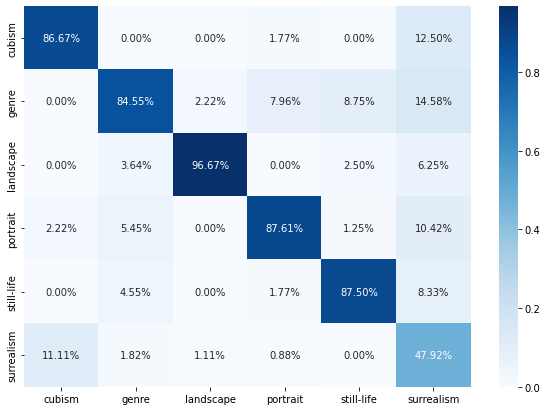

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

array = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(array, index = [i for i in artCategories],
                  columns = [i for i in artCategories])
plt.figure(figsize = (10,7))
mx = sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', cmap='Blues')
del df_cm

## 4. Saving the best model

Additional performance will be saved along with `Training Loss`, `Validations Loss`, `Accuracy`, `Class Accuracy`

In [22]:
checkpoint = {'training_losses': train_losses,
              'valid_losses': valid_losses,
              'accuracies': accuracies,
              'classes_accuracies':classes_accuracies,
              'state_dict': model.state_dict()}

torch.save(checkpoint, pathToModel)

---
## Data visualization

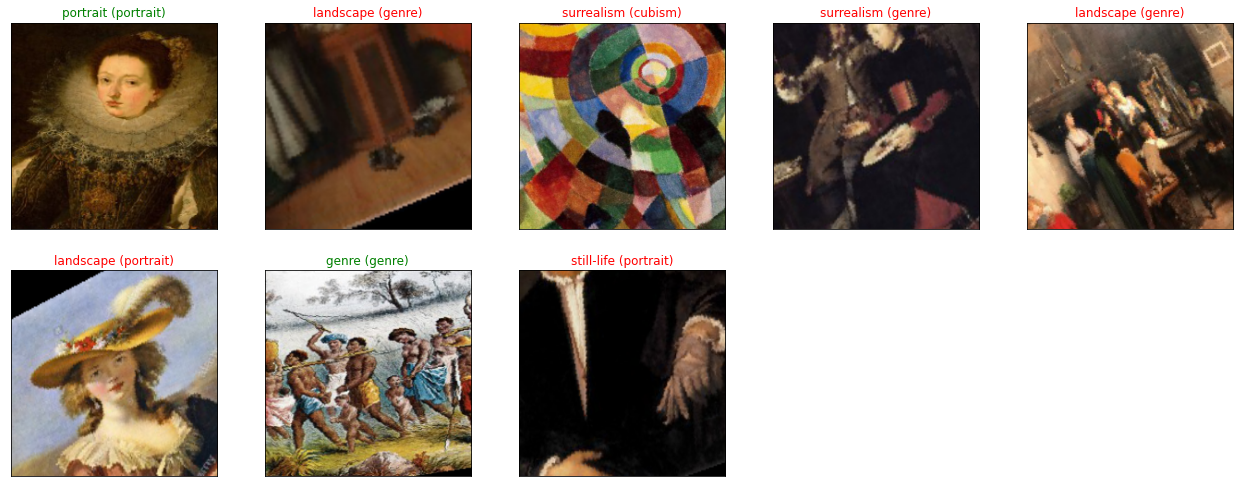

In [24]:
# obtain one batch of test images
dataiter = iter(visualization_dataloader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:    
    images = images.to(device)
    
# get sample outputs
output = model(images)

#move images to CPU for plotting
images = images.cpu()

# convert output probabilities to predicted class
output_ps, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(22, 22))
for idx in np.arange(8):
    ax = fig.add_subplot(5, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(artCategories[preds[idx]], artCategories[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
